<p style="text-align: center; font-size: 30px" > Midterm Assignment </p>

<p style="text-align: right; font-size: 20px"> BRI519 (Fall/2025) </p>

<p style="text-align: right; font-size: 15px"> Provided on November 6 (Thursday) and due on November 17 (Monday) </p>

<br>

Your name: JaeRyung Hong
<br>

Your ID: 2025020920




## General Notes 

(i) Please **do not discuss** this assignment with your friends. Instead, develop your own ideas independently, using AI tools if necessary. If you use any AI tools, **explicitly state which tools were used in the corresponding notebook cell**. 

(ii) When solving each (sub-)problem, feel free to use **multiple Python and/or Markdown cells** as needed. 

(iii) Please write your responses in **English**. 

<br>

Please submit your jupyter-notebook file, **"bri519_2025fall_midterm_yourname_id.ipynb"**, to the TA (neti2207@korea.ac.kr) and instructor (jonghwan_lee@korea.ac.kr) <br>

If you have any issues, please reach out to the TA via an email.    <br>


## Question: mouseLFPAnalysis
[**Goal**] Write low-level Python code to perform analyses of LFP data (mouseLFP.mat) recorded from the mouse auditory cortex in response to tone stimuli.

<br>
Please complete the following tasks:

(a) Run the MATLAB script **mouseLFPAnalysisProgram.m**, familiarize yourself with the overall analysis steps and the dataset (**mouseLFP.mat**), and then perform the corresponding analyses.

(b) Write Python code to analyze the LFP data following the steps outlined below.


(1) **Initial Step**: Start from a blank workspace and define the necessary constant variables.


In [2]:
import numpy as np
from scipy.io import loadmat


cutoff_frequency = 1e3
bin_width = 5
max_freq = 200
num_trials = 200
num_sessions = 4
fs = 1e4

# 100, 150 ms
stim_onset_ms = 100
stim_offset_ms = 150

stim_onset_sample = int(stim_onset_ms / 1000 * fs)
stim_offset_sample = int(stim_offset_ms / 1000 * fs)

In [3]:
import os 
os.chdir('/bci_midterm/')

(2) **Loader**: Load the dataset, "**mouseLFP.mat**" and assign the key data and parameters to appropriate variables


In [4]:

mat = loadmat("mouseLFP.mat", squeeze_me=True, struct_as_record=False)

DATA = mat["DATA"]

num_sessions = DATA.shape[0]

example_session_signals = DATA[0, 0]   # shape: (n_trials, n_samples)
n_trials_per_session = example_session_signals.shape[0]
n_samples = example_session_signals.shape[1]

### <span style="color:red"> (3) Outlier Sample Rejection </span>
### <span style="color:red"> 채점 : 17 / 20 </span>
### <span style="color:red"> 사유 : 근거 및 시각화 부족 </span>

(3) **Outlier Sample Rejection**

* The dataset was acquired from four sessions (200 trials per session), each containing either low or high auditory tone stimuli and the measured LFP signals.

* The stimulus onset and offset were 100 ms and 150 ms.

* Upon inspecting the raw data, you may notice that some trials show noisy or outlier measurements. 

* Develop a method or set of criteria to identify and exclude outlier trials from the raw data, and show the results.

* Clearly explain your reasoning for the chosen outlier detection criteria.

* Report the number of trials available before and after outlier rejection for each session.

* Report the number of trials available across all four sessions for each tone condition after outlier exclusion.

In [5]:

def detect_outliers_rms(trials_2d, z_thresh=3.0):
    # RMS for each trial
    rms = np.sqrt(np.mean(trials_2d**2, axis=1))  # (n_trials,)

    # z-score 
    mean_rms = np.mean(rms)
    std_rms = np.std(rms)
    z = (rms - mean_rms) / (std_rms + 1e-12)

    keep_mask = np.abs(z) <= z_thresh

    return keep_mask, rms, z

per_session_counts = [] 
total_low_after = 0
total_high_after = 0


for session_idx in range(num_sessions):
    # LFP data for session (trial x time)
    session_signals = DATA[session_idx, 0]
    # tone 정보 (low / high tone)
    tone_labels = DATA[session_idx, 4]

    # tone
    unique_tones = np.unique(tone_labels)
    low_tone_code = np.min(unique_tones)
    high_tone_code = np.max(unique_tones)

    # trial index correspoing to the tone
    low_indices = np.where(tone_labels == low_tone_code)[0]
    high_indices = np.where(tone_labels == high_tone_code)[0]

    # extracting raw data for each toen
    low_trials = session_signals[low_indices, :]   # shape: (n_low_trials, n_samples)
    high_trials = session_signals[high_indices, :] # shape: (n_high_trials, n_samples)

    # low tone
    low_keep_mask, low_rms, low_z = detect_outliers_rms(low_trials, z_thresh=3.0)
    low_clean = low_trials[low_keep_mask, :]

    n_low_before = low_trials.shape[0]
    n_low_after = low_clean.shape[0]
    n_low_rejected = n_low_before - n_low_after

    # high tone
    high_keep_mask, high_rms, high_z = detect_outliers_rms(high_trials, z_thresh=3.0)
    high_clean = high_trials[high_keep_mask, :]

    n_high_before = high_trials.shape[0]
    n_high_after = high_clean.shape[0]
    n_high_rejected = n_high_before - n_high_after

    per_session_counts.append({
        "session": session_idx + 1,
        "low_before": n_low_before,
        "low_after": n_low_after,
        "low_rejected": n_low_rejected,
        "high_before": n_high_before,
        "high_after": n_high_after,
        "high_rejected": n_high_rejected
    })

    total_low_after += n_low_after
    total_high_after += n_high_after


print("=== # trial per session (per-tone, berfore/after rejecting outliers) ===")
for summary in per_session_counts:
    s = summary["session"]
    print(f"[Session {s}]")
    print(f"  Low tone  : before = {summary['low_before']:3d}, "
          f"after = {summary['low_after']:3d}, "
          f"rejected = {summary['low_rejected']:3d}")
    print(f"  High tone : before = {summary['high_before']:3d}, "
          f"after = {summary['high_after']:3d}, "
          f"rejected = {summary['high_rejected']:3d}")
    print()

print()
print(f"The number of trials of low tone: {total_low_after}")
print(f"The number of trials of high tone: {total_high_after}")


=== # trial per session (per-tone, berfore/after rejecting outliers) ===
[Session 1]
  Low tone  : before = 101, after = 101, rejected =   0
  High tone : before =  99, after =  97, rejected =   2

[Session 2]
  Low tone  : before = 101, after =  98, rejected =   3
  High tone : before =  99, after =  96, rejected =   3

[Session 3]
  Low tone  : before = 101, after = 101, rejected =   0
  High tone : before =  99, after =  98, rejected =   1

[Session 4]
  Low tone  : before =  99, after =  97, rejected =   2
  High tone : before = 101, after =  97, rejected =   4


The number of trials of low tone: 397
The number of trials of high tone: 388


(4) **Filtering**

* Design a 10th-order Butterworth low-pass filter with a cutoff frequency of 1000 Hz using the `scipy.signal.butter` function.

* Apply the filter to each trial in each session using the `scipy.signal.filtfilt` function.

In [6]:
from scipy.signal import butter, filtfilt

# 10th Butterworth low-pass filter
cutoff_hz = 1000.0
nyquist = fs / 2.0
order = 10

Wn = cutoff_hz / nyquist
b, a = butter(order, Wn, btype='low', analog=False)


low_pass_data = []

for session_idx in range(num_sessions):
    session_signals = DATA[session_idx, 0]  # shape: (n_trials, n_samples)
    n_trials, n_samples = session_signals.shape

    filtered_session = np.zeros_like(session_signals)

    for trial_idx in range(n_trials):
        raw_trial = session_signals[trial_idx, :]   # one trial (1D)
        filtered_trial = filtfilt(b, a, raw_trial)  # zero-phase filtering
        filtered_session[trial_idx, :] = filtered_trial

    low_pass_data.append(filtered_session)


(5) **Main Analysis**

(i) Propose two different ideas or methods to analyze the LFP signals in response to low and high tone stimuli, and describe each approach below.

(ii) Apply both methods to the LFP data for each session, present the results in both the time and frequency domains, and discuss your findings.

### <span style="color:red"> (5-1) Method 1 </span>
### <span style="color:red"> 채점 : 18 / 20 </span>
### <span style="color:red"> 사유 : PSD, 정량정 비교 등 설명 및 해석 부족. </span>

(Idea/Method 1)

With time domain average LFP (ERP) and PSD, it is a simple and clear comparison of overall response size, latency, and band-specific power differences between tone conditions and sessions.

Code implementation below with results and discussion

In [8]:
clean_low = []   # clean_low[session] -> (n_trials_clean, n_samples)
clean_high = []

for session_idx in range(num_sessions):
    session_signals = low_pass_data[session_idx]    # filtered signals
    tone_labels = DATA[session_idx, 4]

    # low / high tone 구분
    unique_tones = np.unique(tone_labels)
    low_tone_code = np.min(unique_tones)
    high_tone_code = np.max(unique_tones)

    low_idx = np.where(tone_labels == low_tone_code)[0]
    high_idx = np.where(tone_labels == high_tone_code)[0]

    low_trials = session_signals[low_idx, :]
    high_trials = session_signals[high_idx, :]

    # removing outliers
    low_keep_mask, _, _ = detect_outliers_rms(low_trials, z_thresh=3.0)
    high_keep_mask, _, _ = detect_outliers_rms(high_trials, z_thresh=3.0)

    clean_low.append(low_trials[low_keep_mask, :])
    clean_high.append(high_trials[high_keep_mask, :])

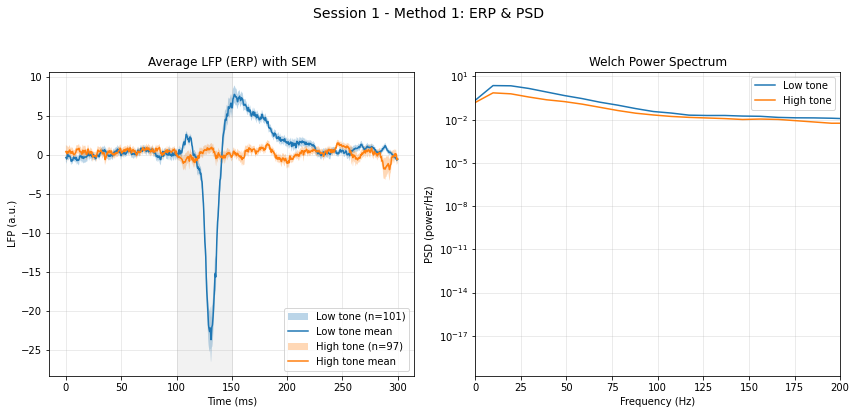

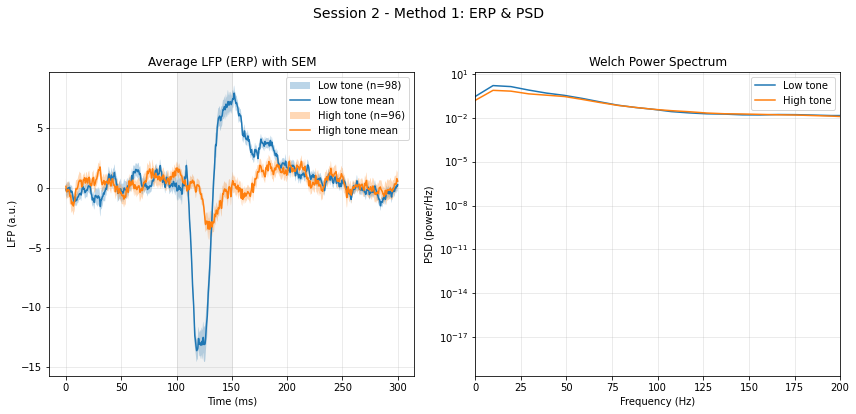

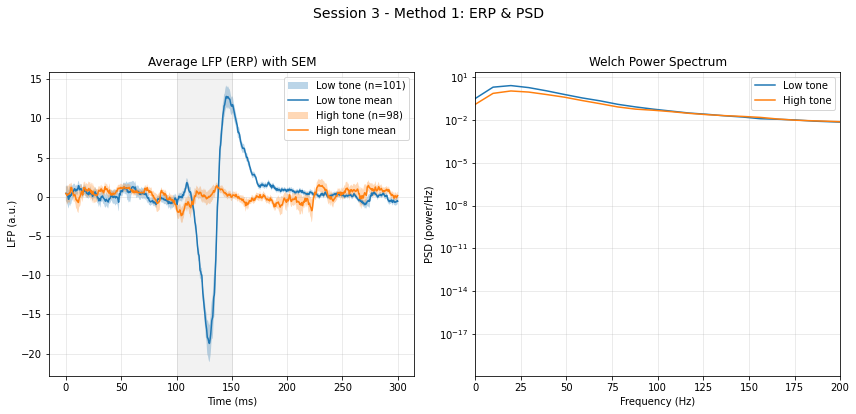

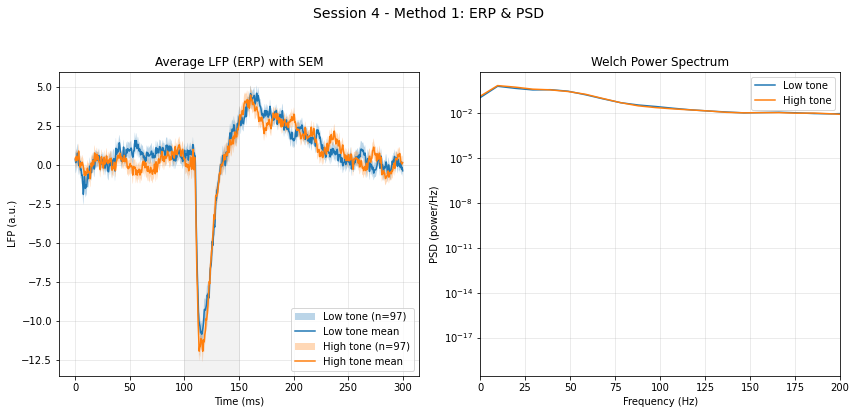

In [9]:
for session_idx in range(num_sessions):
    low_trials = clean_low[session_idx]
    high_trials = clean_high[session_idx]

    n_low = low_trials.shape[0]
    n_high = high_trials.shape[0]
    n_samples = low_trials.shape[1]

    time_ms = np.arange(n_samples) / fs * 1000.0

    # avg and SEM
    mean_low = np.mean(low_trials, axis=0)
    mean_high = np.mean(high_trials, axis=0)

    sem_low = np.std(low_trials, axis=0, ddof=1) / np.sqrt(n_low)
    sem_high = np.std(high_trials, axis=0, ddof=1) / np.sqrt(n_high)

    # PSD (Welch, avg of trial)
    def avg_psd(trials, fs, nperseg=1024):
        psd_acc = None
        for tr in trials:
            f, Pxx = welch(tr, fs=fs, nperseg=nperseg)
            if psd_acc is None:
                psd_acc = Pxx
            else:
                psd_acc += Pxx
        psd_avg = psd_acc / trials.shape[0]
        return f, psd_avg

    f_low, psd_low = avg_psd(low_trials, fs)
    f_high, psd_high = avg_psd(high_trials, fs)

    # plotting time area (ERP) + freq area (PSD)
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Session {session_idx + 1} - Method 1: ERP & PSD", fontsize=14)

    # time area
    plt.subplot(1, 2, 1)
    plt.fill_between(time_ms, mean_low - sem_low, mean_low + sem_low,
                     alpha=0.3, label=f"Low tone (n={n_low})")
    plt.plot(time_ms, mean_low, label="Low tone mean")
    plt.fill_between(time_ms, mean_high - sem_high, mean_high + sem_high,
                     alpha=0.3, label=f"High tone (n={n_high})")
    plt.plot(time_ms, mean_high, label="High tone mean")

    # (100–150 ms)
    plt.axvspan(stim_onset_ms, stim_offset_ms, color="gray", alpha=0.1)

    plt.xlabel("Time (ms)")
    plt.ylabel("LFP (a.u.)")
    plt.title("Average LFP (ERP) with SEM")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # freq area
    plt.subplot(1, 2, 2)
    plt.semilogy(f_low, psd_low, label="Low tone")
    plt.semilogy(f_high, psd_high, label="High tone")
    plt.xlim(0, 200) 
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (power/Hz)")
    plt.title("Welch Power Spectrum")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### <span style="color:red"> (5-2) Method 2 </span>
### <span style="color:red"> 채점 : 12 / 15 </span>
### <span style="color:red"> 사유 : 정량적 분석, 해석 부족 </span>

(Idea/Method 2)

It is an approach that provides a detailed view of how much the frequency band increases/decreases at a certain point before/after stimulation by averaging the trial-specific spectrograms.

Code implementation below with results and discussion

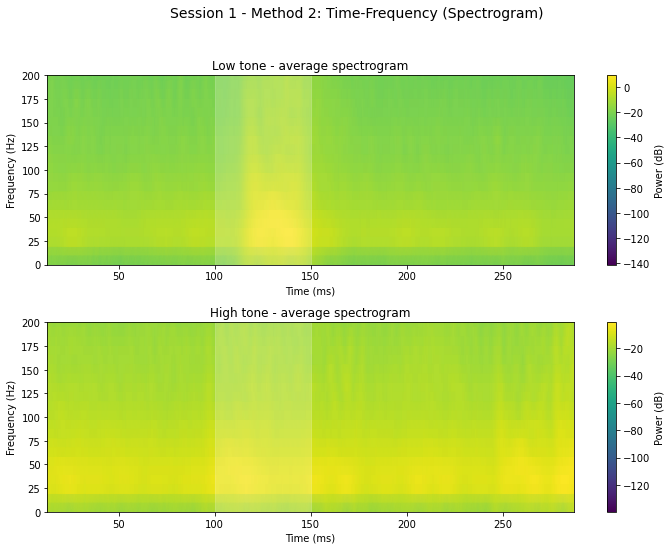

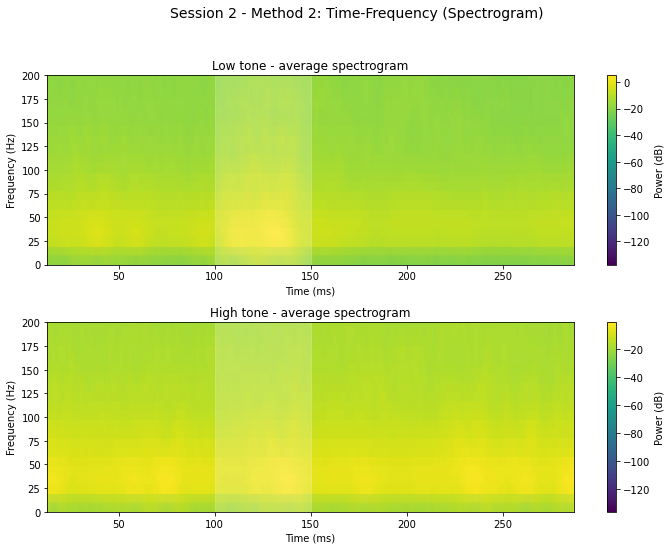

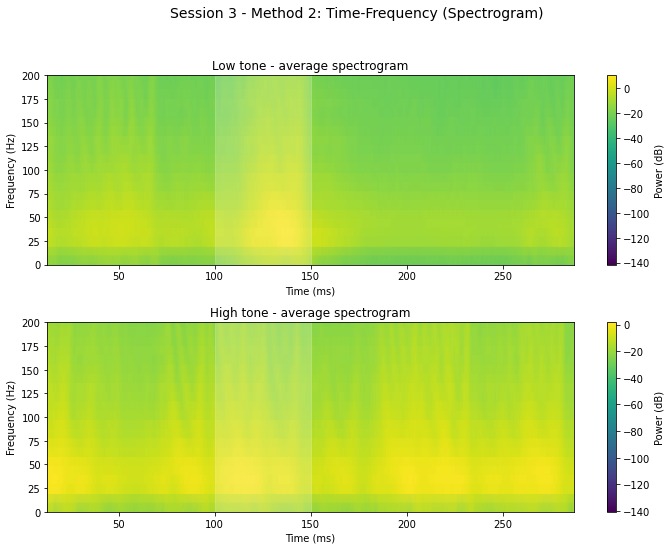

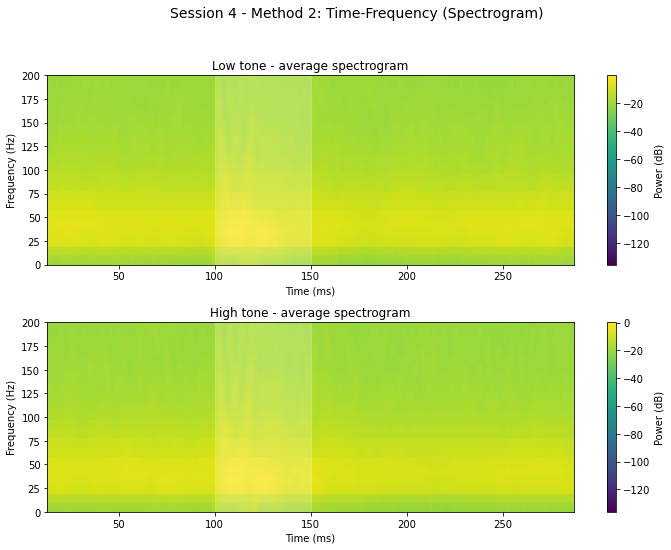

In [10]:
for session_idx in range(num_sessions):
    low_trials = clean_low[session_idx]
    high_trials = clean_high[session_idx]

    nperseg = 256
    noverlap = 255
    nfft = np.arange(0, 200+5, 5)   # 0~200 Hz, 5 Hz step 

    nfft = 512

    # computinga trial average spectrogram for a single tone
    def avg_spectrogram(trials, fs, nperseg, noverlap, nfft):
        S_acc = None
        for tr in trials:
            f, t_spec, Sxx = spectrogram(tr, fs=fs, nperseg=nperseg,
                                         noverlap=noverlap, nfft=nfft,
                                         scaling='density', mode='psd')
            if S_acc is None:
                S_acc = Sxx
            else:
                S_acc += Sxx
        S_avg = S_acc / trials.shape[0]
        # converting to dB scale
        S_db = 10 * np.log10(S_avg + 1e-20)
        return f, t_spec, S_db

    f_low, t_low, S_low = avg_spectrogram(low_trials, fs, nperseg, noverlap, nfft)
    f_high, t_high, S_high = avg_spectrogram(high_trials, fs, nperseg, noverlap, nfft)

    # second -> ms
    t_low_ms = t_low * 1000.0
    t_high_ms = t_high * 1000.0

    # low / high tone spectrogram
    plt.figure(figsize=(10, 8))
    plt.suptitle(f"Session {session_idx + 1} - Method 2: Time-Frequency (Spectrogram)", fontsize=14)

    plt.subplot(2, 1, 1)
    plt.pcolormesh(t_low_ms, f_low, S_low, shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.axvspan(stim_onset_ms, stim_offset_ms, color="white", alpha=0.2)
    plt.ylim(0, 200)
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Low tone - average spectrogram")

    plt.subplot(2, 1, 2)
    plt.pcolormesh(t_high_ms, f_high, S_high, shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.axvspan(stim_onset_ms, stim_offset_ms, color="white", alpha=0.2)
    plt.ylim(0, 200)
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")
    plt.title("High tone - average spectrogram")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

(iii) Apply both methods to the **LFP data combined across the four sessions**, present the results in **both the time and frequency domains**, and discuss your findings, including a **comparison with the results obtained from analyzing each session separately**.


In [11]:
from scipy.signal import welch, spectrogram


fs = 1e4  # sampling frequency
stim_onset_ms = 100
stim_offset_ms = 150

# ------------------------------------------------------------
# collecting 4 sessions' clean trials for each tone
#  - clean_low[i] : (n_trials_i, n_samples)
#  - clean_high[i] : (n_trials_i, n_samples)
# ------------------------------------------------------------
all_low = np.concatenate(clean_low, axis=0)    # shape: (N_low_total, n_samples)
all_high = np.concatenate(clean_high, axis=0)  # shape: (N_high_total, n_samples)

n_low_all, n_samples = all_low.shape
n_high_all, _ = all_high.shape

time_ms = np.arange(n_samples) / fs * 1000.0


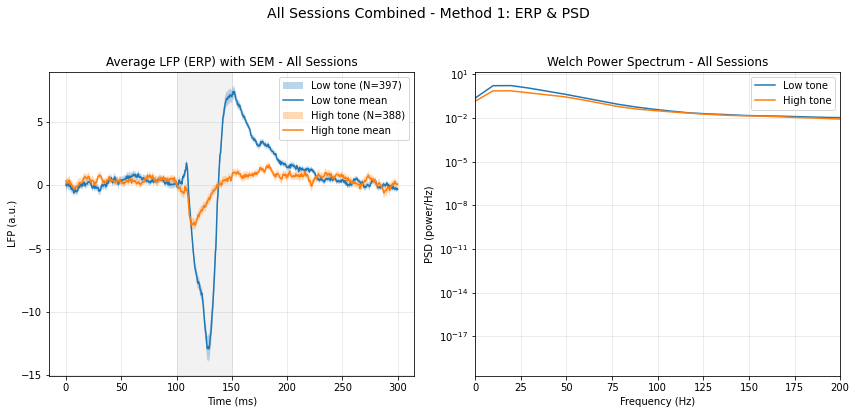

In [12]:
# ERP + PSD (for all 4 session data)

# avg and SEM
mean_low_all = np.mean(all_low, axis=0)
mean_high_all = np.mean(all_high, axis=0)

sem_low_all = np.std(all_low, axis=0, ddof=1) / np.sqrt(n_low_all)
sem_high_all = np.std(all_high, axis=0, ddof=1) / np.sqrt(n_high_all)

# PSD (Welch, avg of total trials)
def avg_psd(trials, fs, nperseg=1024):
    psd_acc = None
    for tr in trials:
        f, Pxx = welch(tr, fs=fs, nperseg=nperseg)
        if psd_acc is None:
            psd_acc = Pxx
        else:
            psd_acc += Pxx
    psd_avg = psd_acc / trials.shape[0]
    return f, psd_avg

f_low_all, psd_low_all = avg_psd(all_low, fs)
f_high_all, psd_high_all = avg_psd(all_high, fs)


# 그림: time area ERP + freq area PSD
plt.figure(figsize=(12, 6))
plt.suptitle("All Sessions Combined - Method 1: ERP & PSD", fontsize=14)

# time area (ERP)
plt.subplot(1, 2, 1)
plt.fill_between(time_ms,
                 mean_low_all - sem_low_all,
                 mean_low_all + sem_low_all,
                 alpha=0.3,
                 label=f"Low tone (N={n_low_all})")
plt.plot(time_ms, mean_low_all, label="Low tone mean")

plt.fill_between(time_ms,
                 mean_high_all - sem_high_all,
                 mean_high_all + sem_high_all,
                 alpha=0.3,
                 label=f"High tone (N={n_high_all})")
plt.plot(time_ms, mean_high_all, label="High tone mean")

plt.axvspan(stim_onset_ms, stim_offset_ms, color="gray", alpha=0.1)
plt.xlabel("Time (ms)")
plt.ylabel("LFP (a.u.)")
plt.title("Average LFP (ERP) with SEM - All Sessions")
plt.legend()
plt.grid(True, alpha=0.3)

# freq area (PSD)
plt.subplot(1, 2, 2)
plt.semilogy(f_low_all, psd_low_all, label="Low tone")
plt.semilogy(f_high_all, psd_high_all, label="High tone")
plt.xlim(0, 200)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (power/Hz)")
plt.title("Welch Power Spectrum - All Sessions")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


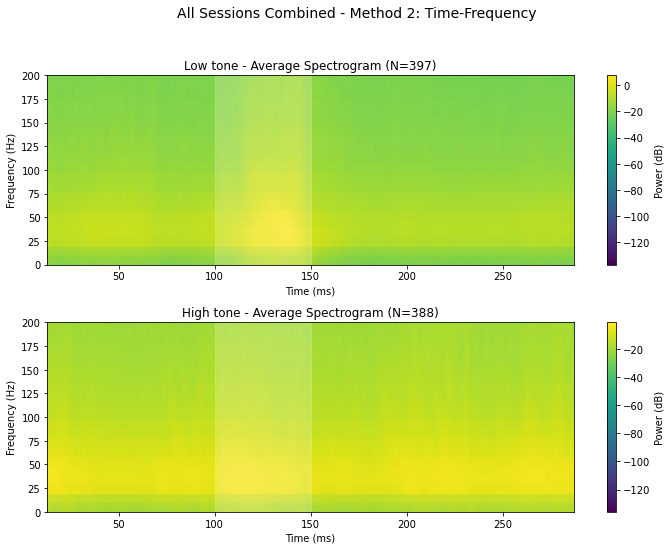

In [13]:
# Time-Frequency (Spectrogram) - for all seseeion trials

nperseg = 256
noverlap = 255
nfft = 512  

f_low_all, t_low_all, S_low_all = avg_spectrogram(all_low, fs, nperseg, noverlap, nfft)
f_high_all, t_high_all, S_high_all = avg_spectrogram(all_high, fs, nperseg, noverlap, nfft)

t_low_ms_all = t_low_all * 1000.0
t_high_ms_all = t_high_all * 1000.0


# Low / High tone spectrogram for all sessions

plt.figure(figsize=(10, 8))
plt.suptitle("All Sessions Combined - Method 2: Time-Frequency", fontsize=14)

plt.subplot(2, 1, 1)
plt.pcolormesh(t_low_ms_all, f_low_all, S_low_all, shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.axvspan(stim_onset_ms, stim_offset_ms, color="white", alpha=0.2)
plt.ylim(0, 200)
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Low tone - Average Spectrogram (N={n_low_all})")

plt.subplot(2, 1, 2)
plt.pcolormesh(t_high_ms_all, f_high_all, S_high_all, shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.axvspan(stim_onset_ms, stim_offset_ms, color="white", alpha=0.2)
plt.ylim(0, 200)
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"High tone - Average Spectrogram (N={n_high_all})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Discuss the findings 

Session-by-session analysis reveals noticeable variability in ERP shape, response strength, and spectral features, reflecting differences in recording quality and neural state. In contrast, combining all four sessions greatly increases the number of trials, producing smoother ERPs with smaller variability and clearer stimulus-related peaks. Likewise, pooled PSDs and spectrograms become more stable and highlight tone-dependent differences that may be inconsistent or masked by noise in individual sessions. Overall, separate analyses show how responses vary across sessions, while the combined analysis emphasizes the common, reliable LFP patterns associated with each tone.

(6) **Save the Results**

* Store your outputs, including the **raw data**, **low-pass filtered data**, and **main analysis results**.

In [14]:
raw_data_3d = np.stack([DATA[i, 0] for i in range(num_sessions)], axis=0)
low_pass_3d = np.stack(low_pass_data, axis=0)

n_sessions, n_trials, n_samples = raw_data_3d.shape
time_ms = np.arange(n_samples) / fs * 1000.0

# ERP per session (clean_low / clean_high)
erp_mean_low_sessions = np.zeros((num_sessions, n_samples))
erp_mean_high_sessions = np.zeros((num_sessions, n_samples))

# computing PSD (Welch, avg of trials)
def avg_psd(trials, fs, nperseg=1024):
    psd_acc = None
    for tr in trials:
        f, Pxx = welch(tr, fs=fs, nperseg=nperseg)
        if psd_acc is None:
            psd_acc = Pxx
        else:
            psd_acc += Pxx
    psd_avg = psd_acc / trials.shape[0]
    return f, psd_avg




psd_f = None
psd_low_sessions = []
psd_high_sessions = []

for session_idx in range(num_sessions):
    low_trials = clean_low[session_idx]   # (n_low_clean, n_samples)
    high_trials = clean_high[session_idx] # (n_high_clean, n_samples)

    # ERP (mean)
    erp_mean_low_sessions[session_idx, :] = np.mean(low_trials, axis=0)
    erp_mean_high_sessions[session_idx, :] = np.mean(high_trials, axis=0)

    # PSD
    f_l, psd_l = avg_psd(low_trials, fs)
    f_h, psd_h = avg_psd(high_trials, fs)

    if psd_f is None:
        psd_f = f_l  

    psd_low_sessions.append(psd_l)
    psd_high_sessions.append(psd_h)

psd_low_sessions = np.stack(psd_low_sessions, axis=0)   # (session, freq)
psd_high_sessions = np.stack(psd_high_sessions, axis=0) # (session, freq)

# computing ERP, PSD for total 4 session trials
# ------------------------------------------------
all_low = np.concatenate(clean_low, axis=0)    # (N_low_total, n_samples)
all_high = np.concatenate(clean_high, axis=0)  # (N_high_total, n_samples)

erp_mean_low_all = np.mean(all_low, axis=0)
erp_mean_high_all = np.mean(all_high, axis=0)

f_low_all, psd_low_all = avg_psd(all_low, fs)
f_high_all, psd_high_all = avg_psd(all_high, fs)


# dictionary for saving the results

results_dict = {
    "fs": fs,
    "stim_onset_ms": stim_onset_ms,
    "stim_offset_ms": stim_offset_ms,

    "raw_data": raw_data_3d,         # (session, trial, time)
    "low_pass_data": low_pass_3d,    # (session, trial, time)

    "clean_low": np.array(clean_low, dtype=object),
    "clean_high": np.array(clean_high, dtype=object),

    # time-area ERP
    "time_ms": time_ms,
    "erp_mean_low_sessions": erp_mean_low_sessions,   # (session, time)
    "erp_mean_high_sessions": erp_mean_high_sessions,  # (session, time)
    "erp_mean_low_all": erp_mean_low_all,             # (time,)
    "erp_mean_high_all": erp_mean_high_all,           # (time,)

    # freq area PSD
    "psd_f": psd_f,                         # (freq,)
    "psd_low_sessions": psd_low_sessions,   # (session, freq)
    "psd_high_sessions": psd_high_sessions,  # (session, freq)
    "psd_low_all": psd_low_all,             # (freq,)
    "psd_high_all": psd_high_all,           # (freq,)

    "per_session_counts": np.array(per_session_counts, dtype=object),
}

#saving 
np.savez("lfp_analysis_results.npz", **results_dict)

print("Saved: lfp_analysis_results.npz")


Saved: lfp_analysis_results.npz


I tried to get help from AI only with what methodology analysis I could apply, but I didn't know what the proposed methodology was and how to draw, so I used AI tool almoost everywhere actually...... Instead, I tried to understand what all the codes meant as much as I could.


End of assignment